In [1]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Load the data sheet
df = pd.read_excel('EastWestAirlines.xlsx' ,sheet_name='data')

# Drop ID
df_clean = df.drop(columns=['ID#'])

In [3]:
# EDA
print(df_clean.info())
print("\nMissing Values:", df_clean.isnull().sum().sum())

# Standardization
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clean)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Balance            3999 non-null   int64
 1   Qual_miles         3999 non-null   int64
 2   cc1_miles          3999 non-null   int64
 3   cc2_miles          3999 non-null   int64
 4   cc3_miles          3999 non-null   int64
 5   Bonus_miles        3999 non-null   int64
 6   Bonus_trans        3999 non-null   int64
 7   Flight_miles_12mo  3999 non-null   int64
 8   Flight_trans_12    3999 non-null   int64
 9   Days_since_enroll  3999 non-null   int64
 10  Award?             3999 non-null   int64
dtypes: int64(11)
memory usage: 343.8 KB
None

Missing Values: 0


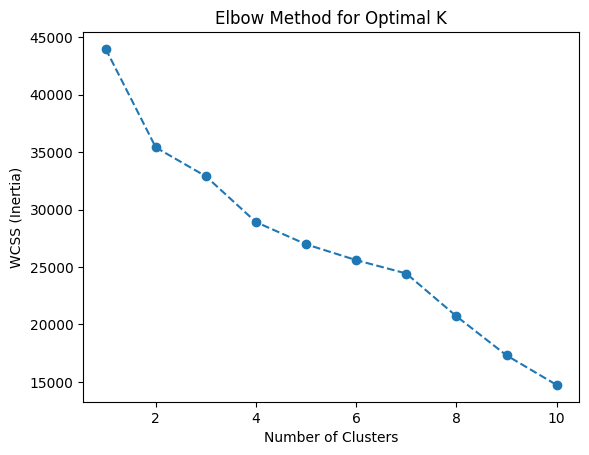

In [4]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Inertia)')
plt.show()

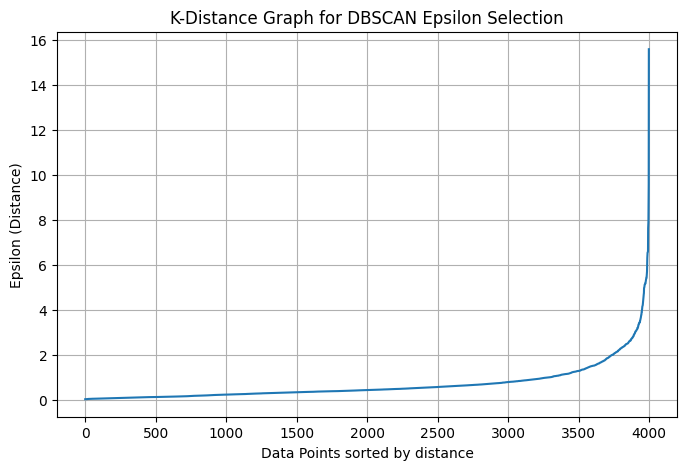

In [5]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

min_pts = 5

# Calculate the distance to the 4th nearest neighbor
neighbors = NearestNeighbors(n_neighbors=min_pts)
neighbors_fit = neighbors.fit(df_scaled)
distances, indices = neighbors_fit.kneighbors(df_scaled)

# Sort and plot the distances
distances = np.sort(distances[:, min_pts-1], axis=0)
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.title('K-Distance Graph for DBSCAN Epsilon Selection')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('Epsilon (Distance)')
plt.grid(True)
plt.show()

In [6]:
# eps, min_samples
dbscan = DBSCAN(eps=1.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(df_scaled)

print("DBSCAN unique clusters found:", set(dbscan_labels))

DBSCAN unique clusters found: {0, 1, 2, 3, 4, -1}


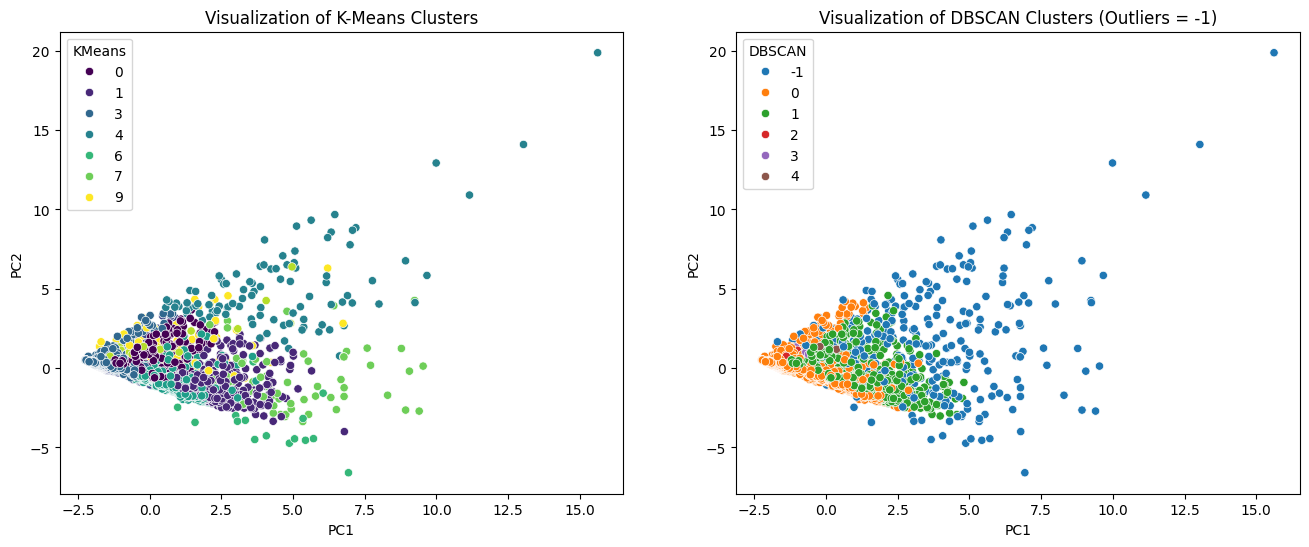

In [7]:

# Reduce the scaled data to 2D for plotting
pca = PCA(n_components=2)
pca_data = pca.fit_transform(df_scaled)
pca_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2'])

# Add the cluster labels from your previous tasks
pca_df['KMeans'] = kmeans.labels_
pca_df['DBSCAN'] = dbscan.labels_

plt.figure(figsize=(16, 6))

# K-Means Scatter Plot
plt.subplot(1, 2, 1)
sns.scatterplot(x='PC1', y='PC2', hue='KMeans', data=pca_df, palette='viridis')
plt.title('Visualization of K-Means Clusters')

# DBSCAN Scatter Plot
plt.subplot(1, 2, 2)
sns.scatterplot(x='PC1', y='PC2', hue='DBSCAN', data=pca_df, palette='tab10')
plt.title('Visualization of DBSCAN Clusters (Outliers = -1)')

plt.show()

In [8]:
# Final K-Means
kmeans_final = KMeans(n_clusters=5, random_state=42).fit(df_scaled)
kmeans_labels = kmeans_final.labels_

print(f"K-Means Silhouette Score: {silhouette_score(df_scaled, kmeans_labels):.4f}")

# Filter out noise (-1) for DBSCAN silhouette score calculation
if len(set(dbscan_labels)) > 1:
    print(f"DBSCAN Silhouette Score (excluding noise): {silhouette_score(df_scaled[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1]):.4f}")

K-Means Silhouette Score: 0.2005
DBSCAN Silhouette Score (excluding noise): 0.2940


In [9]:
eps_options = [0.3, 0.5, 0.8]
min_pts_options = [5, 10]

for eps in eps_options:
    for m_pts in min_pts_options:
        dbscan = DBSCAN(eps=eps, min_samples=m_pts)
        labels = dbscan.fit_predict(df_scaled)

        # Count clusters (excluding noise)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        if n_clusters > 1:
            score = silhouette_score(df_scaled[labels != -1], labels[labels != -1])
            print(f"Trial: eps={eps}, minPts={m_pts} -> Clusters: {n_clusters}, Silhouette: {score:.4f}")
        else:
            print(f"Trial: eps={eps}, minPts={m_pts} -> Failed to form multiple clusters.")

Trial: eps=0.3, minPts=5 -> Clusters: 23, Silhouette: -0.0879
Trial: eps=0.3, minPts=10 -> Clusters: 6, Silhouette: 0.2009
Trial: eps=0.5, minPts=5 -> Clusters: 16, Silhouette: 0.1440
Trial: eps=0.5, minPts=10 -> Clusters: 9, Silhouette: 0.1656
Trial: eps=0.8, minPts=5 -> Clusters: 8, Silhouette: 0.2275
Trial: eps=0.8, minPts=10 -> Clusters: 3, Silhouette: 0.2602


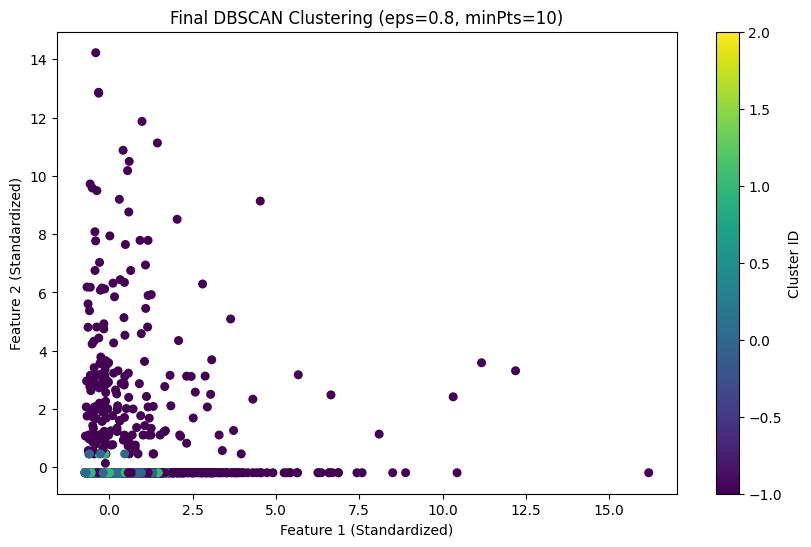

In [10]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Apply the justified parameters
dbscan_final = DBSCAN(eps=0.8, min_samples=10)
final_labels = dbscan_final.fit_predict(df_scaled)

# Visualize the final clusters
plt.figure(figsize=(10, 6))
plt.scatter(df_scaled[:, 0], df_scaled[:, 1], c=final_labels, cmap='viridis', marker='o', s=30)
plt.title('Final DBSCAN Clustering (eps=0.8, minPts=10)')
plt.xlabel('Feature 1 (Standardized)')
plt.ylabel('Feature 2 (Standardized)')
plt.colorbar(label='Cluster ID')
plt.show()

CLUSTERING ANALYSIS

Understanding and Implementing K-Means and DBSCAN Algorithms

Objective:

The objective of this assignment is to introduce to various clustering algorithms, including K-Means, hierarchical, and DBSCAN, and provide hands-on experience in applying these techniques to a real-world dataset.

Datasets :

Data Preprocessing:

1.	Preprocess the dataset to handle missing values, remove outliers, and scale the features if necessary.
2.	Perform exploratory data analysis (EDA) to gain insights into the distribution of data and identify potential clusters.
3.	Use multiple visualizations to understand the hidden patterns in the dataset

Implementing Clustering Algorithms:

•	Implement the K-Means and DBSCAN algorithms using a programming language such as Python with libraries like scikit-learn.

•	Apply each clustering algorithm to the pre-processed dataset to identify clusters within the data.

•	Experiment with different parameter settings for K-means (Elbow curve for different K values) and DBSCAN (e.g., epsilon, minPts) and evaluate the clustering results.


Cluster Analysis and Interpretation:

•	Analyse the clusters generated by each clustering algorithm and interpret the characteristics of each cluster. Write you insights in few comments.


Visualization:

Visualize the clustering results using scatter plots or other suitable visualization techniques.

Plot the clusters with different colours to visualize the separation of data points belonging to different clusters.

Evaluation and Performance Metrics:

Evaluate the quality of clustering using internal evaluation metrics such as silhouette score for K-Means and DBSCAN.


FINAL JUSTIFICATION:

The selected parameters provide the best balance between identifying meaningful density patterns in the airline data and effectively isolating outliers, ensuring the results are both statistically significant and practically interpretable for business analysis.